# 연예인 분류기

In [1]:
print("hello")

hello


# 데이터 가져오기

In [ ]:
'''
import torch
from bing_image_downloader import downloader
downloader.download("고윤정", limit=80, output_dir="./data", adult_filter_off=True, force_replace=False, timeout=30)
downloader.download("Robert Downey Jr", limit=80, output_dir="./data", adult_filter_off=True, force_replace=False, timeout=30)
downloader.download("Amanda Seyfried", limit=80, output_dir="./data", adult_filter_off=True, force_replace=False, timeout=30)
downloader.download("침착맨", limit=80, output_dir="./data", adult_filter_off=True, force_replace=False, timeout=30)
'''

In [44]:
# ./data/train 폴더와 ./data/test 폴더로 나누기
import os
import shutil
import random

In [ ]:
# ./dataset/train 폴더와 ./dataset/test 폴더로 나누기
def dataset_split(query,train_cnt):

    directory_list = [
        './dataset/train/',
        './dataset/test/',
    ]

    for dir in directory_list:
        if not os.path.isdir(dir+query): #./dataset/train/
            os.makedirs(dir+query)

    cnt = 0
    for file_name in os.listdir(query):
        if cnt < train_cnt:
            print(f'trainset : {file_name}')
            shutil.move(query+'/'+file_name, './dataset/train/'+query+'/'+file_name)
        else:
            print(f'testset : {file_name}')
            shutil.move(query+'/'+file_name, './dataset/test/'+query+'/'+file_name)

            cnt += 1

    shutil.rmtree(query)
dataset_split('고윤정', 60)
dataset_split('Robert Downey Jr', 60)
dataset_split('Amanda Seyfried', 60)
dataset_split('침착맨', 60)

In [ ]:
# ./dataset/train 폴더와 ./dataset/test 폴더로 나누기
# ./dataset/train 폴더와 ./dataset/test 폴더로 나누기
def split_data(source_dir, train_dir, test_dir, split_ratio=0.8):
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    for category in os.listdir(source_dir):
        category_path = os.path.join(source_dir, category)
        if os.path.isdir(category_path):
            images = [img for img in os.listdir(category_path) if img.endswith(('.jpg', '.jpeg', '.png'))]
            random.shuffle(images)
            split_index = int(len(images) * split_ratio)

            for img in images[:split_index]:
                shutil.copy(os.path.join(category_path, img), os.path.join(train_dir, category + "_" + img))
                print(f"Copied {img} to {train_dir}")
            for img in images[split_index:]:
                shutil.copy(os.path.join(category_path, img), os.path.join(test_dir, category + "_" + img))
                print(f"Copied {img} to {test_dir}")
source_directory = "./data"
train_directory = "./dataset/train"
test_directory = "./dataset/test"
split_data(source_directory, train_directory, test_directory)
print("Data split completed.")

# 모델 구성

In [45]:
# library import
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import time

In [46]:
# cuda 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [47]:
# 데이터 전처리
transform_train = transforms.Compose([
    transforms.Resize((224, 224)), # 이미지 크기를 224x224로 조정
    transforms.RandomHorizontalFlip(p=0.5), # 50% 확률로 이미지를 좌우로 뒤집음
    transforms.ToTensor(), # 이미지 데이터를 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet 데이터셋의 평균과 표준편차로 정규화
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)), # 이미지 크기를 224x224로 조정
    transforms.ToTensor(), # 이미지 데이터를 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet 데이터셋의 평균과 표준편차로 정규화
])

In [48]:
# 데이터셋 로드
train_dataset = datasets.ImageFolder(root='./dataset/train', transform=transform_train)
test_dataset = datasets.ImageFolder(root='./dataset/test', transform=transform_test)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
img, lablel = train_dataset[99]
print(img.shape, lablel)
plt.imshow(img.permute(1, 2, 0))
plt.title(f'Label: {lablel}')
plt.show()

In [ ]:
# img를 평균과 표준편차를 이용하여 복원하기: 역정규화
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

img_unnormalized = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
img_unnormalized = img_unnormalized.permute(1, 2, 0)
plt.imshow(img_unnormalized.numpy())
plt.title(f'Unnormalized Label: {lablel}')
plt.show()

In [50]:
# 모델 불러오기 (ResNet-34)
model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4) # 4개의 클래스로 변경, 분류기만 바꿈
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [51]:
for name, param in model.named_parameters():
    if 'fc' not in name: # fc 레이어를 제외한 모든 레이어의 파라미터 업데이트를 False로 설정
        param.requires_grad = False
    print(name, param.requires_grad) # 각 파라미터의 requires_grad 상태 출력

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer1.2.conv1.weight False
layer1.2.bn1.weight False
layer1.2.bn1.bias False
layer1.2.conv2.weight False
layer1.2.bn2.weight False
layer1.2.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer2.2.conv1.weight False
layer2.2.bn1.weight False
layer2.2.bn1

In [ ]:
for param in model.parameters():
    param.requires_grad = False # 모든 파라미터 업데이트를 False로 설정

for name, param in model.named_parameters():
    print(name, param.requires_grad) # 각 파라미터의 requires_grad 상태 출력

In [ ]:
model

In [52]:
# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [53]:
# 클래스 정보 출력
print("train classes:", train_dataset.classes)
print("train class_to_idx:", train_dataset.class_to_idx)

print("test classes:", test_dataset.classes)
print("test class_to_idx:", test_dataset.class_to_idx)

print("len(train_dataset):", len(train_dataset), "num classes:", len(train_dataset.classes))
print("len(test_dataset):", len(test_dataset), "num classes:", len(test_dataset.classes))

train classes: ['Amanda Seyfried', 'Robert Downey Jr', '고윤정', '침착맨']
train class_to_idx: {'Amanda Seyfried': 0, 'Robert Downey Jr': 1, '고윤정': 2, '침착맨': 3}
test classes: ['Amanda Seyfried', 'Robert Downey Jr', '고윤정', '침착맨']
test class_to_idx: {'Amanda Seyfried': 0, 'Robert Downey Jr': 1, '고윤정': 2, '침착맨': 3}
len(train_dataset): 247 num classes: 4
len(test_dataset): 63 num classes: 4


In [54]:
# 모델 학습
import tqdm
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm.tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


100%|██████████| 62/62 [00:06<00:00,  9.52it/s]


Epoch 1/20, Loss: 1.4366


100%|██████████| 62/62 [00:06<00:00,  9.81it/s]


Epoch 2/20, Loss: 1.3337


100%|██████████| 62/62 [00:06<00:00,  9.91it/s]


Epoch 3/20, Loss: 1.2784


100%|██████████| 62/62 [00:07<00:00,  8.85it/s]


Epoch 4/20, Loss: 1.2379


100%|██████████| 62/62 [00:07<00:00,  8.83it/s]


Epoch 5/20, Loss: 1.1561


100%|██████████| 62/62 [00:07<00:00,  8.54it/s]


Epoch 6/20, Loss: 1.1481


100%|██████████| 62/62 [00:07<00:00,  8.83it/s]


Epoch 7/20, Loss: 1.0757


100%|██████████| 62/62 [00:07<00:00,  8.74it/s]


Epoch 8/20, Loss: 1.0602


100%|██████████| 62/62 [00:06<00:00,  8.88it/s]


Epoch 9/20, Loss: 1.0066


100%|██████████| 62/62 [00:07<00:00,  7.98it/s]


Epoch 10/20, Loss: 1.0025


100%|██████████| 62/62 [00:07<00:00,  8.68it/s]


Epoch 11/20, Loss: 0.9840


100%|██████████| 62/62 [00:07<00:00,  8.54it/s]


Epoch 12/20, Loss: 0.9295


100%|██████████| 62/62 [00:07<00:00,  8.54it/s]


Epoch 13/20, Loss: 0.8956


100%|██████████| 62/62 [00:07<00:00,  8.79it/s]


Epoch 14/20, Loss: 0.8673


100%|██████████| 62/62 [00:07<00:00,  8.81it/s]


Epoch 15/20, Loss: 0.8472


100%|██████████| 62/62 [00:07<00:00,  8.56it/s]


Epoch 16/20, Loss: 0.8836


100%|██████████| 62/62 [00:07<00:00,  8.60it/s]


Epoch 17/20, Loss: 0.8662


100%|██████████| 62/62 [00:07<00:00,  8.64it/s]


Epoch 18/20, Loss: 0.8355


100%|██████████| 62/62 [00:06<00:00,  8.87it/s]


Epoch 19/20, Loss: 0.7543


100%|██████████| 62/62 [00:07<00:00,  8.60it/s]

Epoch 20/20, Loss: 0.7973


In [55]:
# 모델 저장
torch.save(model.state_dict(), 'resnet34_transfer.pth')

# 모델 평가

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


Predicted: [0 0 0 0], Actual: [0 0 0 0]


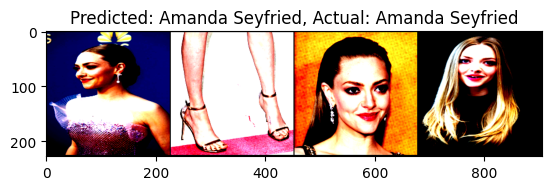

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


Predicted: [0 0 0 0], Actual: [0 0 0 0]


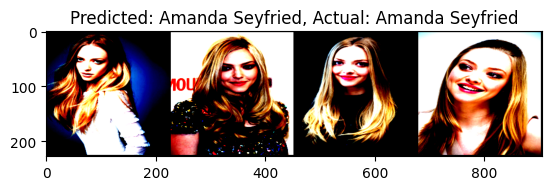

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


Predicted: [2 0 0 0], Actual: [0 0 0 0]


c:\potenup3\dl03\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\potenup3\dl03\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50980 (\N{HANGUL SYLLABLE YUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\potenup3\dl03\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


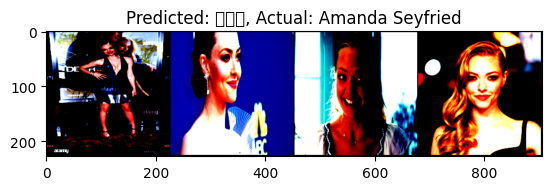

Predicted: [0 0 0 0], Actual: [0 0 0 0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


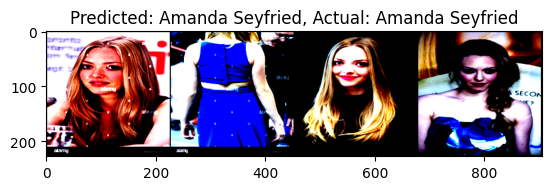

Predicted: [1 1 3 1], Actual: [1 1 1 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


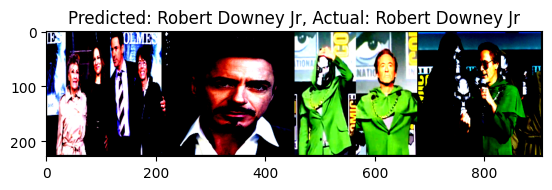

Predicted: [2 1 1 1], Actual: [1 1 1 1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


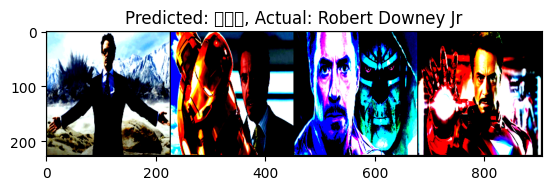

Predicted: [1 1 1 1], Actual: [1 1 1 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


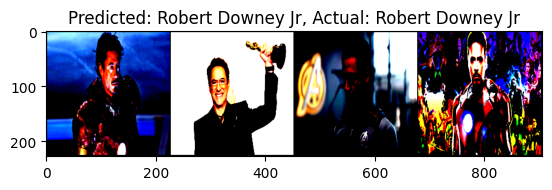

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Predicted: [1 3 1 1], Actual: [1 1 1 1]


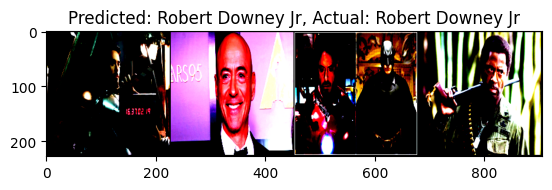

Predicted: [0 0 2 3], Actual: [2 2 2 2]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


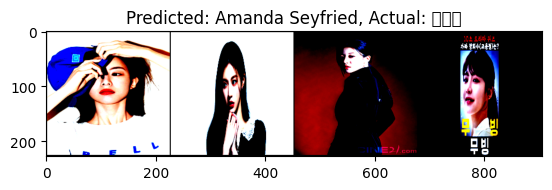

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Predicted: [1 2 2 2], Actual: [2 2 2 2]


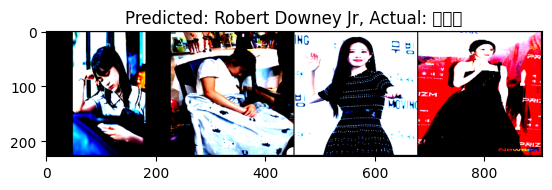

Predicted: [2 2 2 0], Actual: [2 2 2 2]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


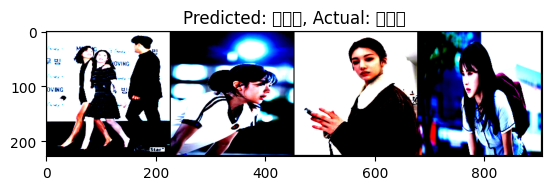

Predicted: [0 0 2 2], Actual: [2 2 2 2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


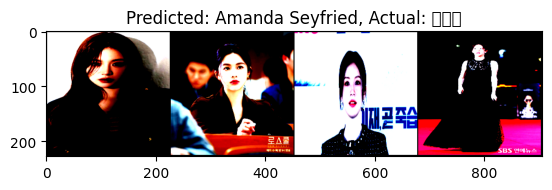

Predicted: [3 1 3 3], Actual: [3 3 3 3]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
c:\potenup3\dl03\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52840 (\N{HANGUL SYLLABLE CIM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\potenup3\dl03\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52265 (\N{HANGUL SYLLABLE CAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\potenup3\dl03\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47592 (\N{HANGUL SYLLABLE MAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


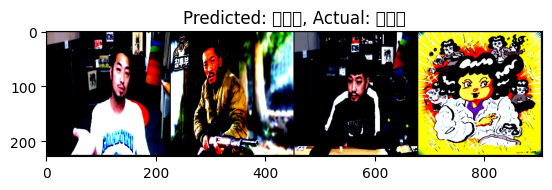

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Predicted: [3 3 2 2], Actual: [3 3 3 3]


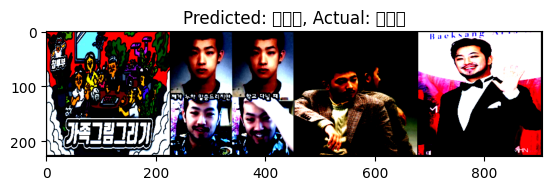

Predicted: [1 3 3 0], Actual: [3 3 3 3]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


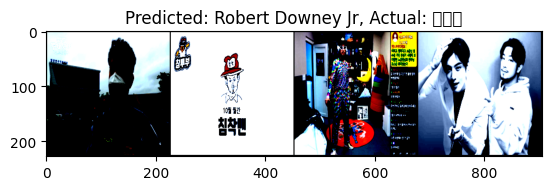

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Predicted: [3 3 3], Actual: [3 3 3]


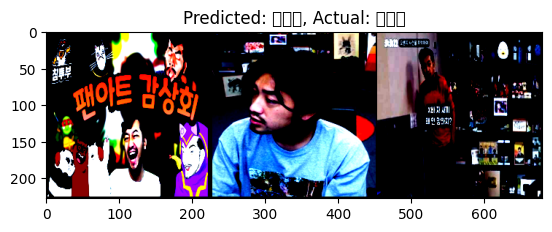

Accuracy: 0.7460


In [56]:
# 모델 평가, image_grid로 예측 결과 출력
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(f'Predicted: {predicted.cpu().numpy()}, Actual: {labels.cpu().numpy()}')
        img_grid = torchvision.utils.make_grid(images.cpu())
        plt.imshow(img_grid.permute(1,2,0))
        plt.title(f'Predicted: {train_dataset.classes[predicted[0]]}, Actual: {train_dataset.classes[labels[0]]}')
        plt.show()
accuracy = correct / total
print(f'Accuracy: {accuracy:.4f}')


# 실증하기

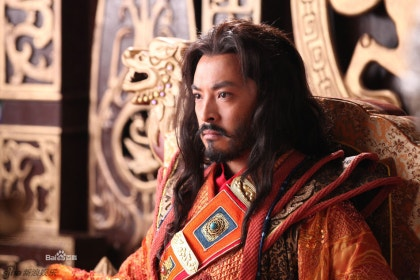

In [57]:
# data\val image 예측
from PIL import Image
image_path = 'data/val/val-01.jpg'
image = Image.open(image_path).convert('RGB')
image


In [58]:
image = transform_test(image).unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output.data, 1)
    print(f'Predicted class index: {predicted.item()}')
    print(f'Predicted class name: {test_dataset.classes[predicted.item()]}')


Predicted class index: 1
Predicted class name: Robert Downey Jr


# 파인튜닝 하기

In [61]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [59]:
# 모델 다시 불러오기
model = models.resnet34(pretrained=True)

for param in model.parameters():
    param.requires_grad = False # 모든 파라미터 업데이트를 False로 설정

model.fc = nn.Linear(model.fc.in_features, 4) # 4개의 클래스로 변경, 분류기만 바꿈
model.to(device)

# layer4의 파라미터 업데이트 허용
for name, param in model.layer4.named_parameters():
    param.requires_grad = True
    print(name, param.requires_grad) # 각 파라미터의 requires_grad 상태 출력

c:\potenup3\dl03\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\potenup3\dl03\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0.conv1.weight True
0.bn1.weight True
0.bn1.bias True
0.conv2.weight True
0.bn2.weight True
0.bn2.bias True
0.downsample.0.weight True
0.downsample.1.weight True
0.downsample.1.bias True
1.conv1.weight True
1.bn1.weight True
1.bn1.bias True
1.conv2.weight True
1.bn2.weight True
1.bn2.bias True
2.conv1.weight True
2.bn1.weight True
2.bn1.bias True
2.conv2.weight True
2.bn2.weight True
2.bn2.bias True


In [60]:
for name, param in model.named_parameters():
    print(name, param.requires_grad) # 각 파라미터의 requires_grad 상태 출력

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer1.2.conv1.weight False
layer1.2.bn1.weight False
layer1.2.bn1.bias False
layer1.2.conv2.weight False
layer1.2.bn2.weight False
layer1.2.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer2.2.conv1.weight False
layer2.2.bn1.weight False
layer2.2.bn1

In [62]:
# 파인 튜닝 학습
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm.tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
print("Fine-tuning completed.")

100%|██████████| 62/62 [00:07<00:00,  8.73it/s]


Epoch 1/20, Loss: 1.5331


100%|██████████| 62/62 [00:06<00:00,  9.31it/s]


Epoch 2/20, Loss: 1.5010


100%|██████████| 62/62 [00:06<00:00,  9.63it/s]


Epoch 3/20, Loss: 1.4978


100%|██████████| 62/62 [00:06<00:00,  9.58it/s]


Epoch 4/20, Loss: 1.5183


100%|██████████| 62/62 [00:07<00:00,  8.38it/s]


Epoch 5/20, Loss: 1.5175


100%|██████████| 62/62 [00:07<00:00,  7.93it/s]


Epoch 6/20, Loss: 1.5248


100%|██████████| 62/62 [00:07<00:00,  8.09it/s]


Epoch 7/20, Loss: 1.5037


100%|██████████| 62/62 [00:07<00:00,  7.98it/s]


Epoch 8/20, Loss: 1.5195


100%|██████████| 62/62 [00:07<00:00,  7.93it/s]


Epoch 9/20, Loss: 1.4987


100%|██████████| 62/62 [00:08<00:00,  7.18it/s]


Epoch 10/20, Loss: 1.5150


100%|██████████| 62/62 [00:08<00:00,  7.34it/s]


Epoch 11/20, Loss: 1.5236


100%|██████████| 62/62 [00:08<00:00,  6.97it/s]


Epoch 12/20, Loss: 1.5078


100%|██████████| 62/62 [00:08<00:00,  7.19it/s]


Epoch 13/20, Loss: 1.5354


100%|██████████| 62/62 [00:08<00:00,  7.33it/s]


Epoch 14/20, Loss: 1.5217


100%|██████████| 62/62 [00:09<00:00,  6.51it/s]


Epoch 15/20, Loss: 1.5382


100%|██████████| 62/62 [00:08<00:00,  7.21it/s]


Epoch 16/20, Loss: 1.5294


100%|██████████| 62/62 [00:08<00:00,  7.24it/s]


Epoch 17/20, Loss: 1.5264


100%|██████████| 62/62 [00:09<00:00,  6.84it/s]


Epoch 18/20, Loss: 1.5007


100%|██████████| 62/62 [00:08<00:00,  7.18it/s]


Epoch 19/20, Loss: 1.4923


100%|██████████| 62/62 [00:11<00:00,  5.41it/s]

Epoch 20/20, Loss: 1.5158
Fine-tuning completed.


In [63]:
# 모델 저장
torch.save(model.state_dict(), 'resnet34_finetune.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


Predicted: [3 0 2 0], Actual: [0 0 0 0]


c:\potenup3\dl03\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52840 (\N{HANGUL SYLLABLE CIM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\potenup3\dl03\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52265 (\N{HANGUL SYLLABLE CAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\potenup3\dl03\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47592 (\N{HANGUL SYLLABLE MAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


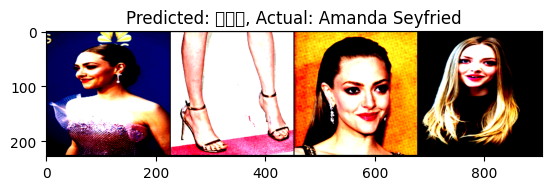

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


Predicted: [0 3 0 2], Actual: [0 0 0 0]


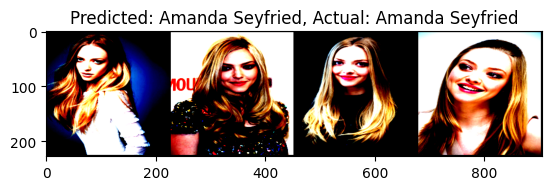

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


Predicted: [0 2 0 0], Actual: [0 0 0 0]


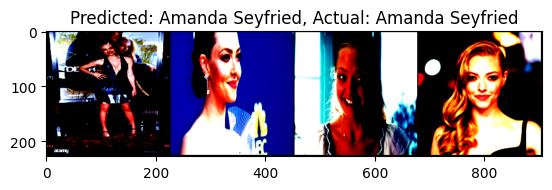

Predicted: [0 0 0 2], Actual: [0 0 0 0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


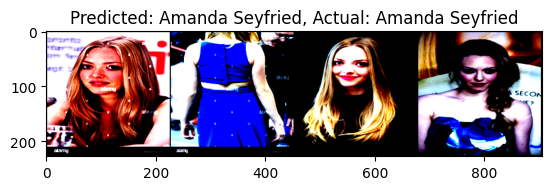

Predicted: [3 0 3 1], Actual: [1 1 1 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


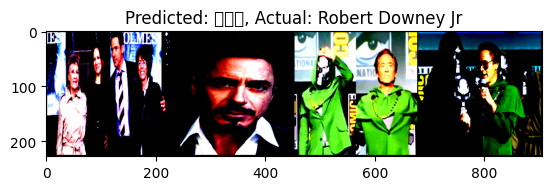

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Predicted: [0 2 0 0], Actual: [1 1 1 1]


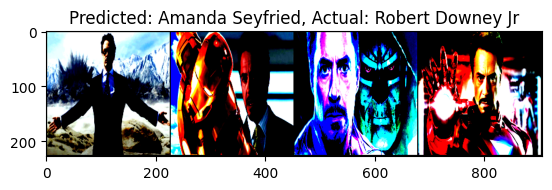

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Predicted: [2 0 0 1], Actual: [1 1 1 1]


c:\potenup3\dl03\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\potenup3\dl03\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50980 (\N{HANGUL SYLLABLE YUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\potenup3\dl03\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


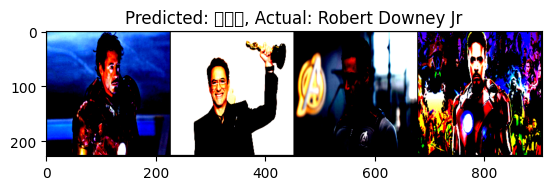

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Predicted: [0 2 0 0], Actual: [1 1 1 1]


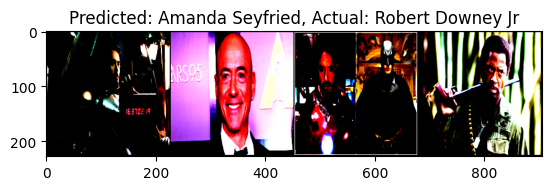

Predicted: [0 0 0 0], Actual: [2 2 2 2]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


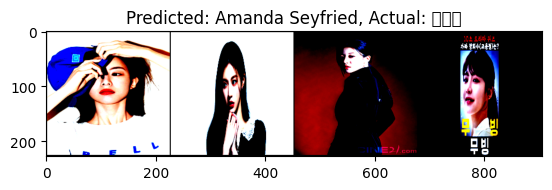

Predicted: [2 3 0 0], Actual: [2 2 2 2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


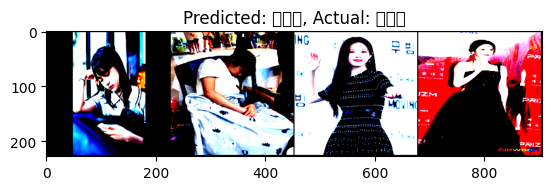

Predicted: [0 0 0 0], Actual: [2 2 2 2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


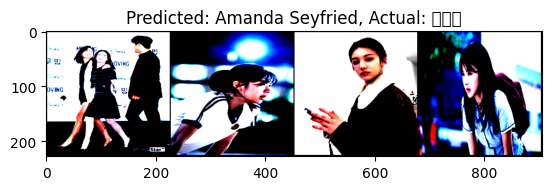

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Predicted: [0 2 2 0], Actual: [2 2 2 2]


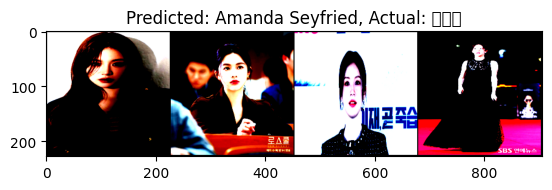

Predicted: [0 0 0 0], Actual: [3 3 3 3]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


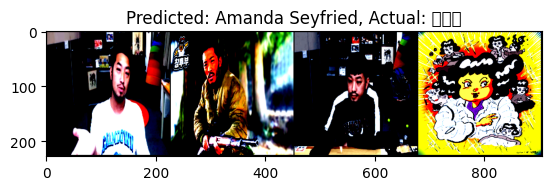

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Predicted: [2 0 0 0], Actual: [3 3 3 3]


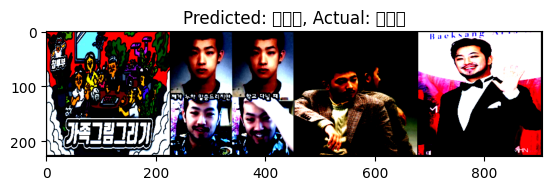

Predicted: [0 2 3 0], Actual: [3 3 3 3]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


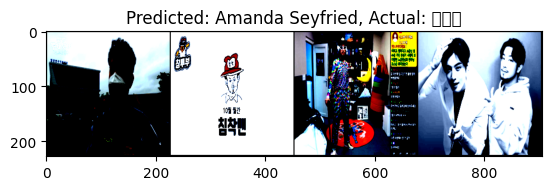

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Predicted: [3 0 1], Actual: [3 3 3]


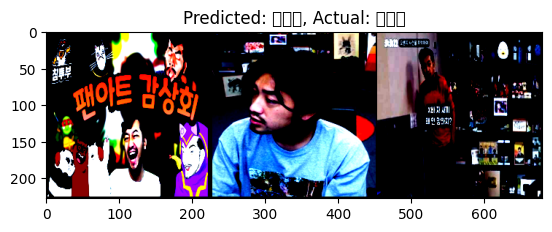

Fine-tuning Accuracy: 0.2698


In [64]:
# 파인 튜닝 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(f'Predicted: {predicted.cpu().numpy()}, Actual: {labels.cpu().numpy()}')
        img_grid = torchvision.utils.make_grid(images.cpu())
        plt.imshow(img_grid.permute(1,2,0))
        plt.title(f'Predicted: {train_dataset.classes[predicted[0]]}, Actual: {train_dataset.classes[labels[0]]}')
        plt.show()
accuracy = correct / total
print(f'Fine-tuning Accuracy: {accuracy:.4f}')

In [ ]:
# convnext 모델 사용하기
import torchvision.models as models


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget